In [1]:
%cd open-images-v5

/mnt/data/object_detection/open-images-v5


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
from tqdm import tqdm
import os
import glob
import re
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

In [3]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(im)
    plt.axis('off');

## 1. Register Datasets

In [4]:
def bbox_rel_to_abs(bbox, height, width):
    """
    Converts bounding box dimensions from relative to absolute pixel values (Detectron2 style).
    See: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.BoxMode
    
    Args:
        bbox (array): relative bounding box in format (x0, x1, y0, y1)
        height (int): height of image
        width (int): width of image
    Return:
        List of absolute bounding box values in format (x0, y0, x1, y1)
    """
    x0 = np.round(np.multiply(bbox[0], width))
    x1 = np.round(np.multiply(bbox[1], width))
    y0 = np.round(np.multiply(bbox[2], height))
    y1 = np.round(np.multiply(bbox[3], height))
    return [x0, y0, x1, y1]

In [5]:
def get_detectron_dicts(img_dir):
    """
    Create a Detectron2's standard dataset dicts from an image folder.
    See: https://detectron2.readthedocs.io/tutorials/datasets.html
    
    Args:
        img_dir (str): path to the image folder (train/validation)
    Return:
        dataset_dicts (list[dict]): List of annotation dictionaries for Detectron2.
    """
    
    # Load annotation DataFrame
    annot_df = pd.read_csv(f"{img_dir}-annotations-bbox-truncated.csv")
    
    # Get all images in `img_dir`
    img_paths = glob.glob(f'{img_dir}/*.jpg')
    
    dataset_dicts = []
    for path in tqdm(img_paths):
        file_name = path
        height, width = cv2.imread(file_name).shape[:2]
        # Get image id from file_name
        img_id = re.findall(f"{img_dir}/(.*).jpg", file_name)[0]
            
        record = {}
        record['file_name'] = file_name
        record['image_id'] = img_id
        record['height'] = height
        record['width'] = width
        
        # Extract bboxes from annotation file
        bboxes = annot_df[['ClassID', 'XMin', 'XMax', 'YMin','YMax']][annot_df['ImageID'] == img_id].values
        annots = []
        for bbox in bboxes:
            # Calculate absolute bounding box
            abs_bbox = bbox_rel_to_abs(bbox[1:], height, width)
            annot = {
                "bbox": abs_bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(bbox[0]),
            }
            annots.append(annot)

        record["annotations"] = annots
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
# Specify target classes and create `class2id` dictionary
target_classes = ['Camera', 'Tripod']
target_classes = sorted(target_classes)
class2id = {class_: id_ for id_, class_ in enumerate(target_classes)}

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog

for d in ["train", "validation"]:
    dataset_name = "camera_tripod_" + d
    print("Registering ", dataset_name)
    DatasetCatalog.register(dataset_name, lambda d=d: get_detectron_dicts(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=target_classes)

detectron_metadata = MetadataCatalog.get("camera_tripod_train")

Registering  camera_tripod_train
Registering  camera_tripod_validation


## 2. Train

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("camera_tripod_train",)
cfg.DATASETS.TEST = ("camera_tripod_validation",)
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025  # 0.01 / (16 / 4), could divide by 5 or 10 for fine-tuning
cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = "./output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/24 21:07:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 6091/6091 [01:37<00:00, 62.40it/s]

[06/24 21:09:00 d2.data.build]: Removed 0 images with no usable annotations. 6091 images left.


[06/24 21:09:00 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   Camera   | 6404         |   Tripod   | 1446         |
|            |              |            |              |
|   total    | 7850         |            |              |
[06/24 21:09:00 d2.data.common]: Serializing 6091 elements to byte tensors and concatenating them all ...
[06/24 21:09:00 d2.data.common]: Serialized dataset takes 2.36 MiB
[06/24 21:09:00 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/24 21:09:00 d2.data.build]: Using training sampler TrainingSampler


Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model!


[06/24 21:09:01 d2.engine.train_loop]: Starting training from iteration 0
[06/24 21:09:07 d2.utils.events]:  eta: 0:00:25  iter: 19  total_loss: 1.433  loss_cls: 1.000  loss_box_reg: 0.473  loss_rpn_cls: 0.019  loss_rpn_loc: 0.008  time: 0.3139  data_time: 0.0247  lr: 0.000050  max_mem: 4745M
[06/24 21:09:13 d2.utils.events]:  eta: 0:00:18  iter: 39  total_loss: 1.126  loss_cls: 0.584  loss_box_reg: 0.511  loss_rpn_cls: 0.014  loss_rpn_loc: 0.010  time: 0.3065  data_time: 0.0100  lr: 0.000100  max_mem: 4781M
[06/24 21:09:19 d2.utils.events]:  eta: 0:00:12  iter: 59  total_loss: 0.968  loss_cls: 0.412  loss_box_reg: 0.505  loss_rpn_cls: 0.014  loss_rpn_loc: 0.010  time: 0.3075  data_time: 0.0099  lr: 0.000150  max_mem: 4781M
[06/24 21:09:26 d2.utils.events]:  eta: 0:00:06  iter: 79  total_loss: 0.890  loss_cls: 0.353  loss_box_reg: 0.508  loss_rpn_cls: 0.019  loss_rpn_loc: 0.007  time: 0.3086  data_time: 0.0103  lr: 0.000200  max_mem: 4781M


100%|██████████| 166/166 [00:02<00:00, 66.18it/s]

[06/24 21:09:35 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   Camera   | 153          |   Tripod   | 40           |
|            |              |            |              |
|   total    | 193          |            |              |
[06/24 21:09:35 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[06/24 21:09:35 d2.data.common]: Serialized dataset takes 0.06 MiB
WARNING [06/24 21:09:35 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[06/24 21:09:35 d2.utils.events]:  eta: 0:00:00  iter: 99  total_loss: 0.874  loss_cls: 0.292  loss_box_reg: 0.496  loss_rpn_cls: 0.013  loss_rpn_loc: 0.010  time: 0.3104  data_time: 0.0104  lr: 0.000250  max_mem: 4781M
[06/24 21:09:35 d2.engine.hooks]: Overall training speed: 97 iterations in 0:00:30 (0.31

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## 3. Inference & evaluation using the trained model

### 3.1. Inference

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("camera_tripod_validation",)
predictor = DefaultPredictor(cfg)

In [10]:
dataset_dicts = get_detectron_dicts("validation")

100%|██████████| 166/166 [00:02<00:00, 68.23it/s]


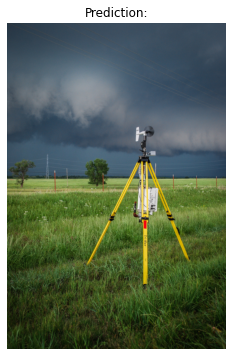

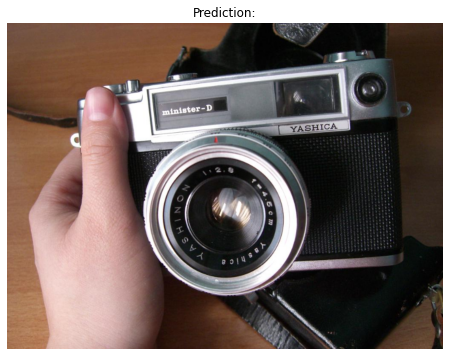

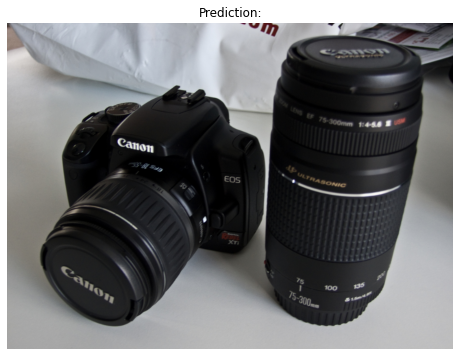

In [11]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=detectron_metadata, 
                   scale=0.8)
    pred = v.draw_instance_predictions(outputs["instances"][:2].to("cpu"))
    cv2_imshow(pred.get_image()[:, :, ::-1])
    plt.title("Prediction:")

### 3.2. Evaluation

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("camera_tripod_validation", cfg, False, output_dir="./output/")
trainer.test(cfg=cfg,
             model=trainer.model,
             evaluators=evaluator)

WARNING [06/24 21:10:21 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'camera_tripod_validation'. Trying to convert it to COCO format ...
WARNING [06/24 21:10:21 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/camera_tripod_validation_coco_format.json'. You need to clear the cache file if your dataset has been modified.


100%|██████████| 166/166 [00:02<00:00, 69.78it/s]

[06/24 21:10:23 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[06/24 21:10:23 d2.data.common]: Serialized dataset takes 0.06 MiB
[06/24 21:10:23 d2.evaluation.evaluator]: Start inference on 166 images


[06/24 21:10:24 d2.evaluation.evaluator]: Inference done 11/166. 0.0383 s / img. ETA=0:00:06
[06/24 21:10:29 d2.evaluation.evaluator]: Inference done 136/166. 0.0384 s / img. ETA=0:00:01
[06/24 21:10:31 d2.evaluation.evaluator]: Total inference time: 0:00:06.509208 (0.040430 s / img per device, on 1 devices)
[06/24 21:10:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.038467 s / img per device, on 1 devices)
[06/24 21:10:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/24 21:10:31 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/24 21:10:31 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.78s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.123
 Aver

OrderedDict([('bbox',
              {'AP': 12.28809981884938,
               'AP50': 28.982376242834114,
               'AP75': 8.706110904113913,
               'APs': nan,
               'APm': 5.937891373469798,
               'APl': 12.650750122456747,
               'AP-Camera': 21.826023084401857,
               'AP-Tripod': 2.7501765532969005})])